In [1]:
import torch
from torch import nn
from torch import optim
from torch import autograd
import numpy as np

from torch.nn import Parameter as P
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import models
import cv2


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import os 

In [2]:
def show_data_batch(batch, max_images=64):
    plt.figure(figsize=(16, 16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch[0][:max_images], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

In [3]:
def show_batch(batch, max_images=64):
    plt.figure(figsize=(16, 16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(batch[0][:max_images], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

In [4]:
class Facades(Dataset):
    def __init__(self, root, transforms = None):
        super(Facades, self).__init__()
        self.root = root
        self.transforms = transforms
        self.files = []
        for folder in os.listdir(root):
            for file in os.listdir(root + '/' + folder):
                self.files.append(root + folder + '/' + file)
            
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, item):
        img = cv2.imread(self.files[item], cv2.IMREAD_COLOR)
        true = img[:, :256, :]
        condition = img[:, 256:, :]
        if self.transforms is not None:
            true = self.transforms(true)
            condition = self.transforms(condition)
        return true, condition

In [5]:
DATA_ROOT = './facades/'
IMAGE_SIZE = 256
BATCH_SIZE = 6
NUM_WORKERS = 0
NUM_TO_SHOW = 8
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

REAL_LABEL = 1.
FAKE_LABEL = 0.
LATENT_DIM = 100
LR = 0.01

In [6]:
dataset = Facades(DATA_ROOT)
true, cond = dataset[0]
#plt.imshow(true)
#plt.imshow(cond)

In [7]:
trf = transforms.Compose([transforms.ToTensor()]) 

dataset = Facades(DATA_ROOT, trf)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                                         drop_last=True, pin_memory=True)

In [8]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, 3, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        #print(x.shape)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.condition_conv = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        self.true_conv = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Linear(512, 1) 
    def forward(self, true, cond):
        cond = self.condition_conv(cond)
        true = self.condition_conv(true)
        x = true - cond
        x = self.pool(x)
        x = x.reshape(BATCH_SIZE, -1)
        return self.lin(x).sigmoid()

In [9]:
generator = Generator()
import segmentation_models_pytorch as smp
generator = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
).to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator = Discriminator()
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
LAMBDA = 5.

In [10]:
def train_epoch_basic(generator, discriminator,
                      optimizer_generator, optimizer_discriminator,
                      dataloader, epoch, num_epochs, device,
                      criterion):
    generator.to(device)
    discriminator.to(device)

    # Logging routine
    generator_loss_list, discriminator_loss_list = [], []
    discriminator_prob_real_list, discriminator_prob_fake_before_list, discriminator_prob_fake_after_list = [], [], []
    generator_images_list = []

    for i, batch in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        discriminator.zero_grad()
        
        ## Train with all-real batch
        # Forward pass real batch through D
        true, cond = batch
        output = discriminator(true.to(device), cond.to(device)).view(-1)
        
        # Calculate loss on all-real batch
        label = torch.full((BATCH_SIZE,), REAL_LABEL, device=device)
        discriminator_loss_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        discriminator_loss_real.backward()
        
        # Save for logging
        discriminator_prob_real = output.mean().item()
        discriminator_prob_real_list.append(discriminator_prob_real)

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1, device=device)
        
        # Generate fake image batch with G
        fake_batch = generator(cond.to(device))
        
        # Classify all fake batch with D
        output = discriminator(fake_batch.detach().to(device), cond.to(device)).view(-1)  # Detach!
        
        # Save for logging
        discriminator_prob_fake_before = output.mean().item()
        discriminator_prob_fake_before_list.append(discriminator_prob_fake_before)
        
        # Calculate D's loss on the all-fake batch
        label.fill_(FAKE_LABEL)
        discriminator_loss_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        discriminator_loss_fake.backward()
        
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        
        # Update D
        optimizer_discriminator.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        generator.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_batch.to(device), cond.to(device)).view(-1)
                
        # Save for logging
        discriminator_prob_fake_after = output.mean().item()
        discriminator_prob_fake_after_list.append(discriminator_prob_fake_after)
        
        # Calculate G's loss based on this output
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        generator_loss = criterion(output.to(device), label.to(device)) + 10. * F.l1_loss(
             generator(cond.to(device)), true.to(device))
        
        # Calculate gradients for G
        generator_loss.backward()
        
        # Update G
        optimizer_generator.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     discriminator_loss.item(), generator_loss.item(), discriminator_prob_real,
                     discriminator_prob_fake_before, discriminator_prob_fake_after))

        # Save Losses for plotting later
        generator_loss_list.append(generator_loss.item())
        discriminator_loss_list.append(discriminator_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if i == len(dataloader) - 1:
            generator.eval()
            with torch.no_grad():
                fake = generator(FIXED_COND.to(device)).detach().cpu()
            generator_images_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            generator.train()

    return {"generator_loss_list": generator_loss_list,
            "discriminator_loss_list": discriminator_loss_list,
            "discriminator_prob_real_list": discriminator_prob_real_list,
            "discriminator_prob_fake_before_list": discriminator_prob_fake_before_list,
            "discriminator_prob_fake_after_list": discriminator_prob_fake_after_list,
            "generator_images_list": generator_images_list}

In [11]:
FIXED_NOISE = torch.randn(5, LATENT_DIM, 1, 1, device=device)
print(FIXED_NOISE.size())

FIXED_TRUE, FIXED_COND = next(iter(dataloader))

torch.Size([5, 100, 1, 1])


In [12]:
results = {key: [] for key in ["generator_loss_list", 
                               "discriminator_loss_list", 
                               "discriminator_prob_real_list", 
                               "discriminator_prob_fake_before_list", "discriminator_prob_fake_after_list",
                               "generator_images_list"]}

In [13]:
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    epoch_results = train_epoch_basic(generator, discriminator, 
                                      optimizer_generator, optimizer_discriminator,
                                      dataloader, epoch, NUM_EPOCHS, device,
                                      criterion)
    #plt.imshow(np.transpose(generator(FIXED_COND.to(device))[0].detach().cpu(), (1,2,0)))
    for key in results:
        results[key].extend(epoch_results[key])

[0/100][0/101]	Loss_D: 1.3935	Loss_G: 10.4445	D(x): 0.4898	D(G(z)): 0.4900 / 0.3699
[0/100][10/101]	Loss_D: 0.6343	Loss_G: 8.9611	D(x): 0.7002	D(G(z)): 0.2357 / 0.2109
[0/100][20/101]	Loss_D: 0.1758	Loss_G: 7.9451	D(x): 0.8879	D(G(z)): 0.0548 / 0.1212
[0/100][30/101]	Loss_D: 0.1207	Loss_G: 9.3460	D(x): 0.9538	D(G(z)): 0.0702 / 0.0258
[0/100][40/101]	Loss_D: 0.0979	Loss_G: 8.5263	D(x): 0.9786	D(G(z)): 0.0728 / 0.0233
[0/100][50/101]	Loss_D: 0.0379	Loss_G: 8.5229	D(x): 0.9716	D(G(z)): 0.0091 / 0.0146
[0/100][60/101]	Loss_D: 0.0572	Loss_G: 7.9699	D(x): 0.9731	D(G(z)): 0.0294 / 0.0129
[0/100][70/101]	Loss_D: 0.0792	Loss_G: 9.2208	D(x): 0.9979	D(G(z)): 0.0738 / 0.0031
[0/100][80/101]	Loss_D: 0.0299	Loss_G: 8.1155	D(x): 0.9872	D(G(z)): 0.0168 / 0.0073
[0/100][90/101]	Loss_D: 0.0182	Loss_G: 8.0537	D(x): 0.9914	D(G(z)): 0.0095 / 0.0054
[0/100][100/101]	Loss_D: 0.0150	Loss_G: 8.2595	D(x): 0.9898	D(G(z)): 0.0047 / 0.0047
[1/100][0/101]	Loss_D: 0.0115	Loss_G: 8.3200	D(x): 0.9919	D(G(z)): 0.0034 /

[8/100][100/101]	Loss_D: 0.0223	Loss_G: 10.9104	D(x): 0.9996	D(G(z)): 0.0216 / 0.0008
[9/100][0/101]	Loss_D: 0.0021	Loss_G: 10.3094	D(x): 1.0000	D(G(z)): 0.0021 / 0.0012
[9/100][10/101]	Loss_D: 0.0297	Loss_G: 8.5006	D(x): 1.0000	D(G(z)): 0.0292 / 0.0076
[9/100][20/101]	Loss_D: 0.0120	Loss_G: 9.1282	D(x): 0.9993	D(G(z)): 0.0112 / 0.0053
[9/100][30/101]	Loss_D: 0.1691	Loss_G: 7.9104	D(x): 0.8699	D(G(z)): 0.0279 / 0.0114
[9/100][40/101]	Loss_D: 0.0001	Loss_G: 13.1155	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[9/100][50/101]	Loss_D: 0.0004	Loss_G: 11.8185	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[9/100][60/101]	Loss_D: 0.0012	Loss_G: 11.7548	D(x): 0.9990	D(G(z)): 0.0003 / 0.0002
[9/100][70/101]	Loss_D: 0.0003	Loss_G: 17.8836	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[9/100][80/101]	Loss_D: 0.7099	Loss_G: 5.0329	D(x): 1.0000	D(G(z)): 0.5005 / 0.2262
[9/100][90/101]	Loss_D: 0.2234	Loss_G: 8.4820	D(x): 1.0000	D(G(z)): 0.1999 / 0.0069
[9/100][100/101]	Loss_D: 0.1518	Loss_G: 7.0101	D(x): 0.9978	D(G(z)): 0

[17/100][80/101]	Loss_D: 0.0074	Loss_G: 9.9392	D(x): 1.0000	D(G(z)): 0.0073 / 0.0019
[17/100][90/101]	Loss_D: 0.1411	Loss_G: 7.6534	D(x): 1.0000	D(G(z)): 0.1314 / 0.0122
[17/100][100/101]	Loss_D: 0.0030	Loss_G: 10.4749	D(x): 0.9985	D(G(z)): 0.0015 / 0.0009
[18/100][0/101]	Loss_D: 0.0181	Loss_G: 8.1502	D(x): 0.9996	D(G(z)): 0.0175 / 0.0089
[18/100][10/101]	Loss_D: 0.7069	Loss_G: 6.7361	D(x): 1.0000	D(G(z)): 0.5042 / 0.0346
[18/100][20/101]	Loss_D: 2.5318	Loss_G: 17.1156	D(x): 1.0000	D(G(z)): 0.9191 / 0.0000
[18/100][30/101]	Loss_D: 0.0336	Loss_G: 7.7898	D(x): 0.9999	D(G(z)): 0.0328 / 0.0120
[18/100][40/101]	Loss_D: 0.0179	Loss_G: 8.3301	D(x): 1.0000	D(G(z)): 0.0177 / 0.0060
[18/100][50/101]	Loss_D: 0.0017	Loss_G: 10.4562	D(x): 0.9998	D(G(z)): 0.0015 / 0.0012
[18/100][60/101]	Loss_D: 0.0026	Loss_G: 14.1372	D(x): 0.9975	D(G(z)): 0.0000 / 0.0000
[18/100][70/101]	Loss_D: 0.0004	Loss_G: 16.2493	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[18/100][80/101]	Loss_D: 0.0006	Loss_G: 12.1732	D(x): 1.0000

[26/100][60/101]	Loss_D: 0.2919	Loss_G: 7.0716	D(x): 0.9999	D(G(z)): 0.2528 / 0.0270
[26/100][70/101]	Loss_D: 0.1873	Loss_G: 6.7924	D(x): 0.9922	D(G(z)): 0.1641 / 0.0328
[26/100][80/101]	Loss_D: 0.8059	Loss_G: 6.2640	D(x): 1.0000	D(G(z)): 0.5488 / 0.0532
[26/100][90/101]	Loss_D: 0.0009	Loss_G: 10.3170	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[26/100][100/101]	Loss_D: 0.2101	Loss_G: 6.4402	D(x): 1.0000	D(G(z)): 0.1890 / 0.0554
[27/100][0/101]	Loss_D: 0.0202	Loss_G: 7.8422	D(x): 1.0000	D(G(z)): 0.0200 / 0.0121
[27/100][10/101]	Loss_D: 0.0191	Loss_G: 7.3265	D(x): 0.9997	D(G(z)): 0.0186 / 0.0251
[27/100][20/101]	Loss_D: 0.1225	Loss_G: 7.9049	D(x): 1.0000	D(G(z)): 0.1152 / 0.0094
[27/100][30/101]	Loss_D: 0.0000	Loss_G: 13.5388	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[27/100][40/101]	Loss_D: 0.8760	Loss_G: 15.6612	D(x): 1.0000	D(G(z)): 0.5805 / 0.0000
[27/100][50/101]	Loss_D: 0.0892	Loss_G: 6.4550	D(x): 1.0000	D(G(z)): 0.0853 / 0.0573
[27/100][60/101]	Loss_D: 0.0998	Loss_G: 6.7753	D(x): 1.0000	D(

[35/100][40/101]	Loss_D: 0.0192	Loss_G: 8.6462	D(x): 1.0000	D(G(z)): 0.0190 / 0.0084
[35/100][50/101]	Loss_D: 0.0697	Loss_G: 7.4146	D(x): 1.0000	D(G(z)): 0.0673 / 0.0186
[35/100][60/101]	Loss_D: 0.0056	Loss_G: 9.1743	D(x): 1.0000	D(G(z)): 0.0056 / 0.0035
[35/100][70/101]	Loss_D: 0.0729	Loss_G: 7.6702	D(x): 1.0000	D(G(z)): 0.0702 / 0.0151
[35/100][80/101]	Loss_D: 0.0896	Loss_G: 7.2944	D(x): 0.9995	D(G(z)): 0.0848 / 0.0214
[35/100][90/101]	Loss_D: 0.3292	Loss_G: 6.5131	D(x): 1.0000	D(G(z)): 0.2766 / 0.0366
[35/100][100/101]	Loss_D: 0.0115	Loss_G: 8.6499	D(x): 1.0000	D(G(z)): 0.0115 / 0.0060
[36/100][0/101]	Loss_D: 0.6267	Loss_G: 9.4508	D(x): 1.0000	D(G(z)): 0.4651 / 0.0030
[36/100][10/101]	Loss_D: 0.5619	Loss_G: 7.3793	D(x): 1.0000	D(G(z)): 0.4260 / 0.0177
[36/100][20/101]	Loss_D: 0.2004	Loss_G: 7.8671	D(x): 1.0000	D(G(z)): 0.1779 / 0.0139
[36/100][30/101]	Loss_D: 0.1602	Loss_G: 7.1155	D(x): 1.0000	D(G(z)): 0.1477 / 0.0263
[36/100][40/101]	Loss_D: 0.0105	Loss_G: 8.5788	D(x): 1.0000	D(G(z

[44/100][20/101]	Loss_D: 0.2176	Loss_G: 6.1826	D(x): 1.0000	D(G(z)): 0.1955 / 0.0626
[44/100][30/101]	Loss_D: 0.1156	Loss_G: 6.4745	D(x): 1.0000	D(G(z)): 0.1091 / 0.0510
[44/100][40/101]	Loss_D: 0.1112	Loss_G: 6.7159	D(x): 1.0000	D(G(z)): 0.1052 / 0.0413
[44/100][50/101]	Loss_D: 0.1066	Loss_G: 6.8998	D(x): 1.0000	D(G(z)): 0.1011 / 0.0333
[44/100][60/101]	Loss_D: 0.1846	Loss_G: 11.3058	D(x): 1.0000	D(G(z)): 0.1679 / 0.0004
[44/100][70/101]	Loss_D: 0.0003	Loss_G: 11.7954	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002
[44/100][80/101]	Loss_D: 0.4388	Loss_G: 7.7240	D(x): 1.0000	D(G(z)): 0.3539 / 0.0146
[44/100][90/101]	Loss_D: 0.0607	Loss_G: 8.3011	D(x): 1.0000	D(G(z)): 0.0588 / 0.0073
[44/100][100/101]	Loss_D: 0.9526	Loss_G: 6.2533	D(x): 1.0000	D(G(z)): 0.6118 / 0.0612
[45/100][0/101]	Loss_D: 0.3223	Loss_G: 6.5745	D(x): 1.0000	D(G(z)): 0.2754 / 0.0517
[45/100][10/101]	Loss_D: 0.5942	Loss_G: 6.9892	D(x): 1.0000	D(G(z)): 0.4469 / 0.0315
[45/100][20/101]	Loss_D: 0.1986	Loss_G: 6.1887	D(x): 1.0000	D(G

[53/100][0/101]	Loss_D: 0.0453	Loss_G: 9.0097	D(x): 1.0000	D(G(z)): 0.0442 / 0.0061
[53/100][10/101]	Loss_D: 0.3593	Loss_G: 5.8994	D(x): 1.0000	D(G(z)): 0.3012 / 0.1239
[53/100][20/101]	Loss_D: 0.1084	Loss_G: 6.8045	D(x): 1.0000	D(G(z)): 0.1025 / 0.0528
[53/100][30/101]	Loss_D: 0.0670	Loss_G: 7.3575	D(x): 1.0000	D(G(z)): 0.0646 / 0.0283
[53/100][40/101]	Loss_D: 0.0000	Loss_G: 19.5017	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[53/100][50/101]	Loss_D: 0.0647	Loss_G: 8.2610	D(x): 1.0000	D(G(z)): 0.0626 / 0.0111
[53/100][60/101]	Loss_D: 0.5622	Loss_G: 13.9145	D(x): 1.0000	D(G(z)): 0.4267 / 0.0000
[53/100][70/101]	Loss_D: 0.1048	Loss_G: 7.5092	D(x): 1.0000	D(G(z)): 0.0995 / 0.0243
[53/100][80/101]	Loss_D: 0.0233	Loss_G: 8.1115	D(x): 1.0000	D(G(z)): 0.0231 / 0.0122
[53/100][90/101]	Loss_D: 0.1317	Loss_G: 7.0492	D(x): 1.0000	D(G(z)): 0.1230 / 0.0362
[53/100][100/101]	Loss_D: 0.0412	Loss_G: 8.6221	D(x): 1.0000	D(G(z)): 0.0403 / 0.0086
[54/100][0/101]	Loss_D: 0.0108	Loss_G: 8.8707	D(x): 1.0000	D(G(

[61/100][90/101]	Loss_D: 0.4593	Loss_G: 8.2163	D(x): 1.0000	D(G(z)): 0.3676 / 0.0086
[61/100][100/101]	Loss_D: 0.3111	Loss_G: 6.8036	D(x): 1.0000	D(G(z)): 0.2668 / 0.0285
[62/100][0/101]	Loss_D: 0.0760	Loss_G: 6.8098	D(x): 1.0000	D(G(z)): 0.0730 / 0.0351
[62/100][10/101]	Loss_D: 0.4173	Loss_G: 7.9125	D(x): 1.0000	D(G(z)): 0.3398 / 0.0122
[62/100][20/101]	Loss_D: 0.0062	Loss_G: 9.1203	D(x): 1.0000	D(G(z)): 0.0062 / 0.0036
[62/100][30/101]	Loss_D: 0.0635	Loss_G: 6.6946	D(x): 1.0000	D(G(z)): 0.0615 / 0.0400
[62/100][40/101]	Loss_D: 0.1923	Loss_G: 7.8366	D(x): 1.0000	D(G(z)): 0.1743 / 0.0149
[62/100][50/101]	Loss_D: 0.0632	Loss_G: 7.1807	D(x): 1.0000	D(G(z)): 0.0611 / 0.0250
[62/100][60/101]	Loss_D: 0.0308	Loss_G: 7.6419	D(x): 1.0000	D(G(z)): 0.0303 / 0.0160
[62/100][70/101]	Loss_D: 0.5842	Loss_G: 6.4443	D(x): 1.0000	D(G(z)): 0.4407 / 0.0460
[62/100][80/101]	Loss_D: 0.1134	Loss_G: 7.8043	D(x): 1.0000	D(G(z)): 0.1070 / 0.0148
[62/100][90/101]	Loss_D: 0.0597	Loss_G: 7.1409	D(x): 1.0000	D(G(z

[70/100][60/101]	Loss_D: 0.0645	Loss_G: 9.3359	D(x): 0.9403	D(G(z)): 0.0028 / 0.0014
[70/100][70/101]	Loss_D: 0.6169	Loss_G: 3.7863	D(x): 0.6383	D(G(z)): 0.1317 / 0.2604
[70/100][80/101]	Loss_D: 1.1551	Loss_G: 4.0489	D(x): 0.3732	D(G(z)): 0.0326 / 0.2575
[70/100][90/101]	Loss_D: 0.3904	Loss_G: 5.5249	D(x): 0.7018	D(G(z)): 0.0240 / 0.0521
[70/100][100/101]	Loss_D: 0.1200	Loss_G: 6.3174	D(x): 0.9767	D(G(z)): 0.0912 / 0.0206
[71/100][0/101]	Loss_D: 0.0389	Loss_G: 7.8938	D(x): 0.9684	D(G(z)): 0.0065 / 0.0050
[71/100][10/101]	Loss_D: 2.5422	Loss_G: 10.7079	D(x): 0.9996	D(G(z)): 0.8967 / 0.0004
[71/100][20/101]	Loss_D: 1.5051	Loss_G: 10.8291	D(x): 0.9983	D(G(z)): 0.7729 / 0.0003
[71/100][30/101]	Loss_D: 1.5601	Loss_G: 9.2043	D(x): 0.9989	D(G(z)): 0.6449 / 0.0029
[71/100][40/101]	Loss_D: 0.0620	Loss_G: 6.7880	D(x): 0.9506	D(G(z)): 0.0109 / 0.0138
[71/100][50/101]	Loss_D: 2.3562	Loss_G: 8.6637	D(x): 0.9998	D(G(z)): 0.8879 / 0.0030
[71/100][60/101]	Loss_D: 0.1858	Loss_G: 5.7490	D(x): 0.9295	D(G

[79/100][40/101]	Loss_D: 0.0356	Loss_G: 6.7223	D(x): 0.9957	D(G(z)): 0.0308 / 0.0118
[79/100][50/101]	Loss_D: 0.3365	Loss_G: 5.6307	D(x): 0.9849	D(G(z)): 0.2738 / 0.0313
[79/100][60/101]	Loss_D: 1.4088	Loss_G: 7.1255	D(x): 0.9782	D(G(z)): 0.7429 / 0.0055
[79/100][70/101]	Loss_D: 0.2830	Loss_G: 5.7471	D(x): 0.8407	D(G(z)): 0.1023 / 0.0331
[79/100][80/101]	Loss_D: 0.7645	Loss_G: 7.5765	D(x): 0.4752	D(G(z)): 0.0031 / 0.0058
[79/100][90/101]	Loss_D: 0.2055	Loss_G: 5.2965	D(x): 0.9192	D(G(z)): 0.1132 / 0.0537
[79/100][100/101]	Loss_D: 0.3924	Loss_G: 6.0697	D(x): 0.9103	D(G(z)): 0.2521 / 0.0204
[80/100][0/101]	Loss_D: 0.1304	Loss_G: 6.5585	D(x): 0.9024	D(G(z)): 0.0271 / 0.0127
[80/100][10/101]	Loss_D: 0.0697	Loss_G: 4.2551	D(x): 0.9991	D(G(z)): 0.0663 / 0.1243
[80/100][20/101]	Loss_D: 0.0879	Loss_G: 6.8010	D(x): 0.9562	D(G(z)): 0.0419 / 0.0116
[80/100][30/101]	Loss_D: 1.1111	Loss_G: 3.3309	D(x): 0.3475	D(G(z)): 0.0282 / 0.4033
[80/100][40/101]	Loss_D: 0.0141	Loss_G: 6.7129	D(x): 0.9935	D(G(z

[88/100][20/101]	Loss_D: 0.2032	Loss_G: 7.2331	D(x): 0.9912	D(G(z)): 0.1727 / 0.0094
[88/100][30/101]	Loss_D: 0.2305	Loss_G: 7.9910	D(x): 0.8007	D(G(z)): 0.0030 / 0.0034
[88/100][40/101]	Loss_D: 0.1727	Loss_G: 5.9254	D(x): 0.8585	D(G(z)): 0.0195 / 0.0371
[88/100][50/101]	Loss_D: 0.0627	Loss_G: 5.6692	D(x): 1.0000	D(G(z)): 0.0607 / 0.0344
[88/100][60/101]	Loss_D: 0.2225	Loss_G: 6.5586	D(x): 0.9991	D(G(z)): 0.1982 / 0.0163
[88/100][70/101]	Loss_D: 0.0586	Loss_G: 10.4343	D(x): 0.9438	D(G(z)): 0.0004 / 0.0003
[88/100][80/101]	Loss_D: 0.1108	Loss_G: 5.5933	D(x): 0.9707	D(G(z)): 0.0776 / 0.0406
[88/100][90/101]	Loss_D: 0.0091	Loss_G: 9.3988	D(x): 0.9922	D(G(z)): 0.0013 / 0.0010
[88/100][100/101]	Loss_D: 1.3335	Loss_G: 2.8556	D(x): 0.2716	D(G(z)): 0.0170 / 0.5718
[89/100][0/101]	Loss_D: 1.6216	Loss_G: 7.9315	D(x): 0.9967	D(G(z)): 0.7948 / 0.0035
[89/100][10/101]	Loss_D: 0.5878	Loss_G: 6.5810	D(x): 0.9999	D(G(z)): 0.4387 / 0.0108
[89/100][20/101]	Loss_D: 0.0608	Loss_G: 5.1615	D(x): 0.9943	D(G(

[97/100][0/101]	Loss_D: 0.0906	Loss_G: 6.4172	D(x): 0.9985	D(G(z)): 0.0836 / 0.0258
[97/100][10/101]	Loss_D: 0.7624	Loss_G: 6.5318	D(x): 0.7837	D(G(z)): 0.3828 / 0.0179
[97/100][20/101]	Loss_D: 0.0300	Loss_G: 7.6427	D(x): 0.9768	D(G(z)): 0.0066 / 0.0050
[97/100][30/101]	Loss_D: 0.0189	Loss_G: 5.6486	D(x): 0.9995	D(G(z)): 0.0182 / 0.0273
[97/100][40/101]	Loss_D: 0.0238	Loss_G: 7.0980	D(x): 0.9903	D(G(z)): 0.0139 / 0.0094
[97/100][50/101]	Loss_D: 0.0353	Loss_G: 7.1595	D(x): 0.9842	D(G(z)): 0.0191 / 0.0084
[97/100][60/101]	Loss_D: 0.5453	Loss_G: 6.1343	D(x): 0.5957	D(G(z)): 0.0086 / 0.0191
[97/100][70/101]	Loss_D: 0.0968	Loss_G: 6.4839	D(x): 0.9994	D(G(z)): 0.0913 / 0.0171
[97/100][80/101]	Loss_D: 0.0118	Loss_G: 7.2775	D(x): 0.9965	D(G(z)): 0.0082 / 0.0081
[97/100][90/101]	Loss_D: 0.1079	Loss_G: 11.5423	D(x): 0.9004	D(G(z)): 0.0002 / 0.0002
[97/100][100/101]	Loss_D: 0.1924	Loss_G: 7.5980	D(x): 0.9982	D(G(z)): 0.1715 / 0.0088
[98/100][0/101]	Loss_D: 0.6647	Loss_G: 10.6696	D(x): 0.9908	D(G(

In [14]:
torch.save(generator.state_dict(), 'generator.pkl')

In [15]:
#generator.load_state_dict(torch.load('generator.pkl'), strict=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


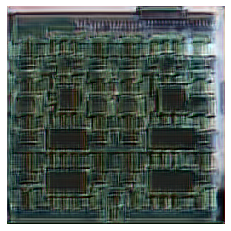

In [26]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[0].detach().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


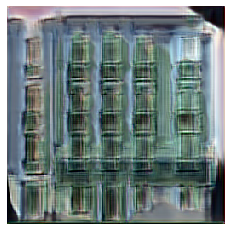

In [27]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[1].detach().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


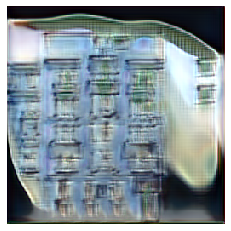

In [28]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[2].detach().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


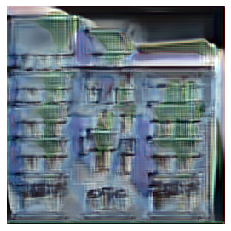

In [29]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[3].detach().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


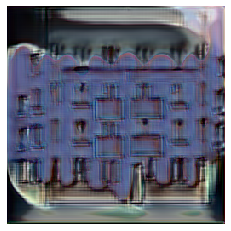

In [30]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[4].detach().cpu(), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


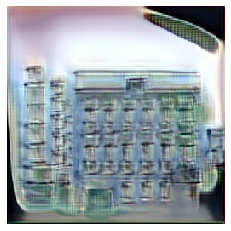

In [22]:
plt.axis("off")
plt.imshow(np.transpose(generator(FIXED_COND.to(device))[5].detach().cpu(), (1,2,0)))

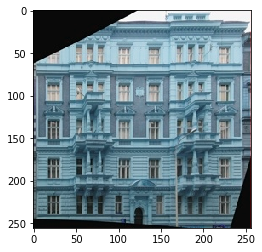

In [31]:
plt.imshow(np.transpose(FIXED_TRUE[0].cpu(), (1,2,0)))

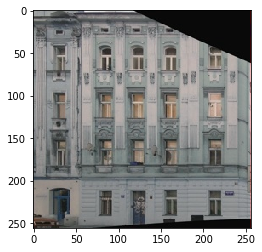

In [23]:
plt.imshow(np.transpose(FIXED_TRUE[1].cpu(), (1,2,0)))

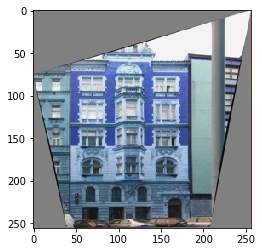

In [24]:
plt.imshow(np.transpose(FIXED_TRUE[2].cpu(), (1,2,0)))

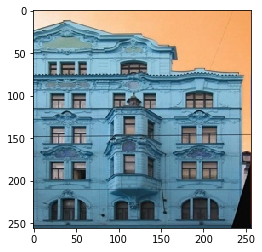

In [25]:
plt.imshow(np.transpose(FIXED_TRUE[3].cpu(), (1,2,0)))

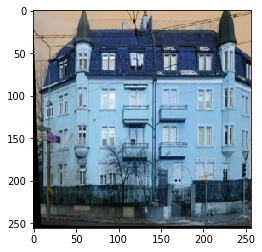

In [32]:
plt.imshow(np.transpose(FIXED_TRUE[4].cpu(), (1,2,0)))

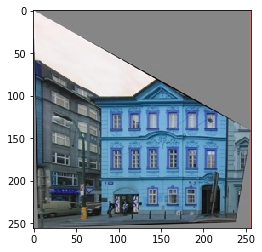

In [33]:
plt.imshow(np.transpose(FIXED_TRUE[5].cpu(), (1,2,0)))

Conlusion: generator started to construct pictures look like facades of houses. For future improovements we need another 100-200 epochs of learning. But I think i will stop here. As it takes a lot of time.